## Under Construction!

i: time index

y: measured y value

y_est: estimated (predicted) y value

w: real paramter value

w_est: estimated parameter value

lr: learning rate

y[i] = w[i]*y[i-1] + random noise

y_est[i] = w_est[i]*y[i-1]

e[i] = y[i] - y_est[i]

w_est[i+1] = w_est[i] + lr*y[i-1]*e[i]


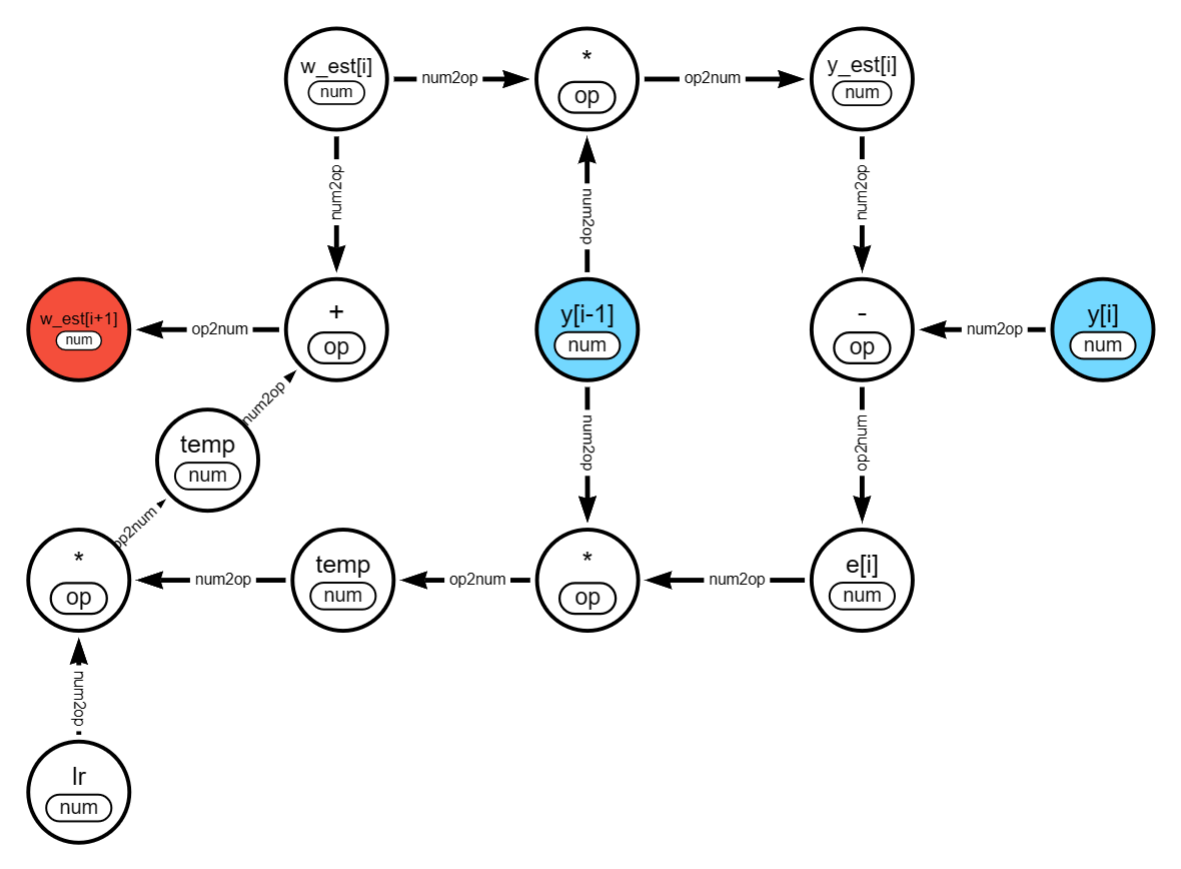

In [13]:
# %pip install trengx==0.0.14

In [1]:
# import os
# from neo4j import GraphDatabase as graphdb
# from trengx import graph

import os
from neo4j import GraphDatabase as graphdb
import sys
sys.path.append('../trengx')
import graph

In [2]:
# Codespaces secrets
uri = os.environ['NEO4J_URI'] # Get the value of the uri variable
user = os.environ.get("NEO4J_USER") # Get the value of the user variable
password= os.getenv("NEO4J_PASSWORD")  # Get the value of the pw variable

# Create Graph Class
g = graph.Graph(graphdb, uri, user, password)

In [3]:
# y_est[i] = w_est[i]*y[i-1]
w_est_i = g.add_node ('num', 'w_est_i', {'value': 0.1})
w_est_i_id = w_est_i['node_id']
y_im1 = g.add_node ('num', 'y_im1 ', {'value': 3.0})
y_im1_id = y_im1['node_id']
mul = g.add_node ('op', '*', {'reverse':False})
mul_id = mul['node_id']
g.add_edge ('num2op', w_est_i_id, mul_id, {'trigger':False})
g.add_edge ('num2op', y_im1_id, mul_id, {'trigger':True})
y_est_i = g.add_node ('num', 'y_est_i', {'value': 2.0})
y_est_i_id = y_est_i['node_id']
g.add_edge ('op2num', mul_id, y_est_i_id)

# e[i] = y[i] - y_est[i]
y_i = g.add_node ('num', 'y_i', {'value': 2.0})
y_i_id = y_i['node_id']
sub = g.add_node ('op', '-', {'reverse':True})
sub_id = sub['node_id']
g.add_edge ('num2op', y_i_id, sub_id, {'trigger':False})
g.add_edge ('num2op', y_est_i_id, sub_id, {'trigger':True})
e_i = g.add_node ('num', 'e_i', {'value': 0.2})
e_i_id = e_i['node_id']
g.add_edge ('op2num', sub_id, e_i_id)

# w_est[i+1] = w_est[i] + lr*y[i-1]*e[i]
mul = g.add_node ('op', '*', {'reverse':False})
mul_id = mul['node_id']
g.add_edge ('num2op', y_im1_id, mul_id, {'trigger':False})
g.add_edge ('num2op', e_i_id, mul_id, {'trigger':True})
temp = g.add_node ('num', 'temp', {'value': 1.0})
temp_id = temp['node_id']
g.add_edge ('op2num', mul_id, temp_id)
lr = g.add_node ('num', 'lr', {'value': 0.001})
lr_id = lr['node_id']
mul = g.add_node ('op', '*', {'reverse':False})
mul_id = mul['node_id']
g.add_edge ('num2op', temp_id, mul_id,{'trigger':True})
g.add_edge ('num2op', lr_id, mul_id, {'trigger':False})
temp = g.add_node ('num', 'temp', {'value': 1.0})
temp_id = temp['node_id']
g.add_edge ('op2num', mul_id, temp_id)
add = g.add_node ('op', '+', {'reverse':False})
add_id = add['node_id']
g.add_edge ('num2op', temp_id, add_id, {'trigger':True})
g.add_edge ('num2op', w_est_i_id, add_id, {'trigger':False})
w_est_ip1 = g.add_node ('num', 'w_est_ip1', {'value': 0.2})
w_est_ip1_id = w_est_ip1['node_id']
g.add_edge ('op2num', add_id, w_est_ip1_id)

g.close()



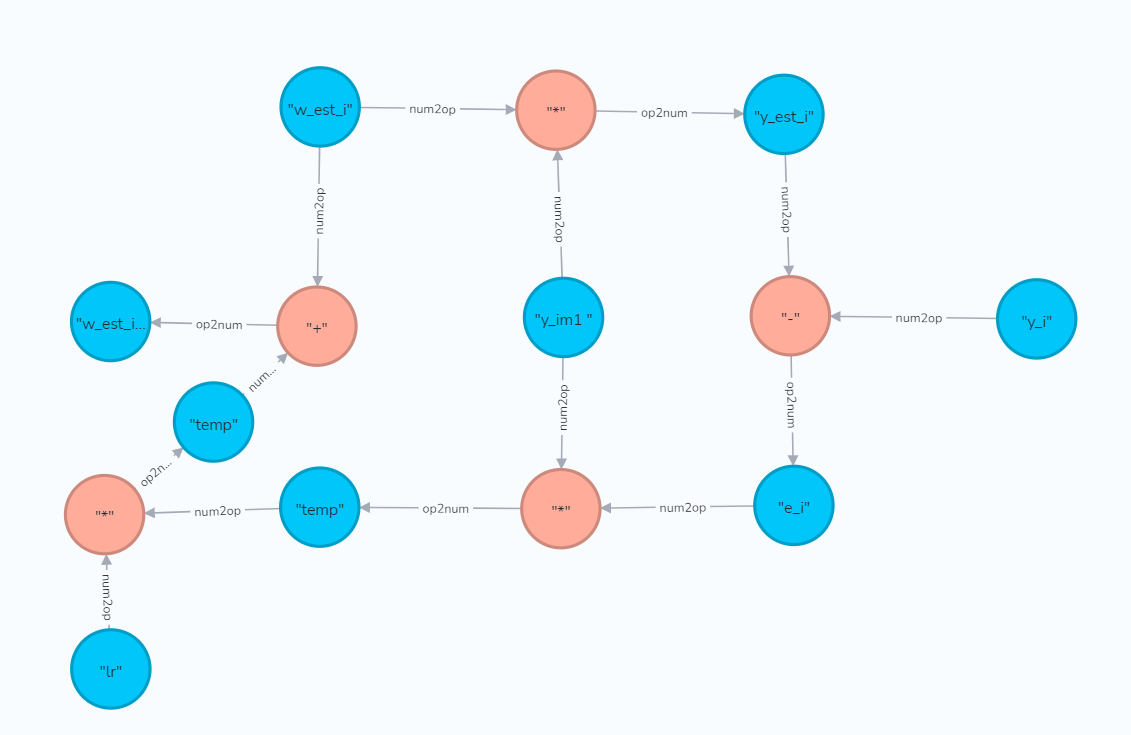

In [4]:
g.set_node_prop(y_im1_id, 'value', 10, True)
g.close()

out_id: 115
out_name: y_est_i
out_value: 1.0
out_id: 118
out_name: e_i
out_value: 1.0
out_id: 120
out_name: temp
out_value: 10.0
out_id: 123
out_name: temp
out_value: 0.01
out_id: 125
out_name: w_est_ip1
out_value: 0.11
